
# Moving Average Convergence Divergence (MACD) analysis

In [696]:
from typing import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.core.interchange.dataframe_protocol import DataFrame

WINDOW_LEN = 1000

In [697]:
# Read stock data
csvFile = pd.read_csv('pkn_orlen.csv', sep=';', usecols=['Data', 'Otwarcie'])
stock_data = csvFile.rename(columns={'Data': 'Date', 'Otwarcie': 'Price'})
stock_data = stock_data.tail(1026)

# Make indexes start at 0
smallest_index = stock_data.index.min()
stock_data.index = stock_data.index - smallest_index

# Fix dates for plotting
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

stock_data

,Date,Price
0,2021-02-09,46.8351
1,2021-02-10,47.4272
2,2021-02-11,46.4455
3,2021-02-12,46.3201
4,2021-02-15,47.3339
...,...,...
1021,2025-03-07,63.4600
1022,2025-03-10,64.4200
1023,2025-03-11,64.7500
1024,2025-03-12,66.2000


In [698]:
def calc_ema(data: DataFrame, n : int) -> DataFrame:
    alpha = 2 / (n + 1)
    prices =  data.iloc[:, 1].to_list()
    ema_values = [prices[0]]
    for i in range(1, len(prices)):
        new_ema = round((alpha * prices[i]) + (1 - alpha) * ema_values[-1], 2)
        ema_values.append(new_ema)
    ema_df = pd.DataFrame({
        'Date' : data['Date'].tail(len(ema_values)),
        f'EMA_{n}': ema_values}
    )
    return ema_df

In [699]:
def calc_macd(data: DataFrame, n1 = 12, n2=26) -> DataFrame:
    ema_1 = calc_ema(data, n1).iloc[:, 1]
    ema_2 = calc_ema(data, n2).iloc[:, 1]
    macd_values = ema_1 - ema_2
    macd_df = pd.DataFrame({
        'Date' : data['Date'].tail(len(macd_values)),
        f'MACD_{n1}_{n2}': macd_values}
    )
    return macd_df

In [700]:
def calc_signal(macd: DataFrame, n = 9):
    return calc_ema(macd, n)


In [701]:
# calculate ema
EMA_12 = calc_ema(stock_data, 12)[-WINDOW_LEN:]
EMA_26 = calc_ema(stock_data, 26)[-WINDOW_LEN:]
EMAS = pd.merge(EMA_12, EMA_26, on='Date')
EMAS

,Date,EMA_12,EMA_26
0,2021-03-17,51.26,49.61
1,2021-03-18,51.18,49.69
2,2021-03-19,50.87,49.65
3,2021-03-22,50.60,49.61
4,2021-03-23,50.51,49.64
...,...,...,...
995,2025-03-07,61.86,59.40
996,2025-03-10,62.25,59.77
997,2025-03-11,62.63,60.14
998,2025-03-12,63.18,60.59


In [702]:
# calculate macd and signal
MACD = calc_macd(stock_data)[-WINDOW_LEN:]
SIGNAL = calc_signal(MACD)[-WINDOW_LEN:]
SIGNAL = SIGNAL.rename(columns={SIGNAL.columns[1]: 'Signal'})
MS = pd.merge(MACD, SIGNAL, on='Date')
MS


,Date,MACD_12_26,Signal
0,2021-03-17,1.65,1.65
1,2021-03-18,1.49,1.62
2,2021-03-19,1.22,1.54
3,2021-03-22,0.99,1.43
4,2021-03-23,0.87,1.32
...,...,...,...
995,2025-03-07,2.46,2.36
996,2025-03-10,2.48,2.38
997,2025-03-11,2.49,2.40
998,2025-03-12,2.59,2.44


In [703]:
def calc_cross_points(macd: DataFrame, signal: DataFrame, prices: DataFrame) -> DataFrame:
    cp = pd.DataFrame(columns=['Date', 'Cross Point', 'Price'])

    for i in range(1, macd.shape[0]):
        date = macd.iloc[i]['Date']
        price = prices[prices['Date'] == date].iloc[0]['Price']
        value = None

        if macd.iloc[i, 1] >= signal.iloc[i, 1] and macd.iloc[i - 1, 1] < signal.iloc[i - 1, 1]:
            value = 'Buy'
        elif macd.iloc[i, 1] <= signal.iloc[i, 1] and macd.iloc[i - 1, 1] > signal.iloc[i - 1, 1]:
            value = 'Sell'
        if value is not None:
            cp.loc[len(cp)] = [date, value, price]
    return cp


In [704]:
# calculate cross points
cross_points = calc_cross_points(MACD, SIGNAL, stock_data)
cross_points

,Date,Cross Point,Price
0,2021-04-08,Buy,52.2745
1,2021-04-12,Sell,50.3258
2,2021-04-16,Buy,52.5080
3,2021-06-10,Sell,62.3426
4,2021-07-29,Buy,60.2317
...,...,...,...
74,2024-11-15,Buy,53.0000
75,2024-12-02,Sell,51.0000
76,2024-12-03,Buy,51.9100
77,2024-12-13,Sell,49.1950


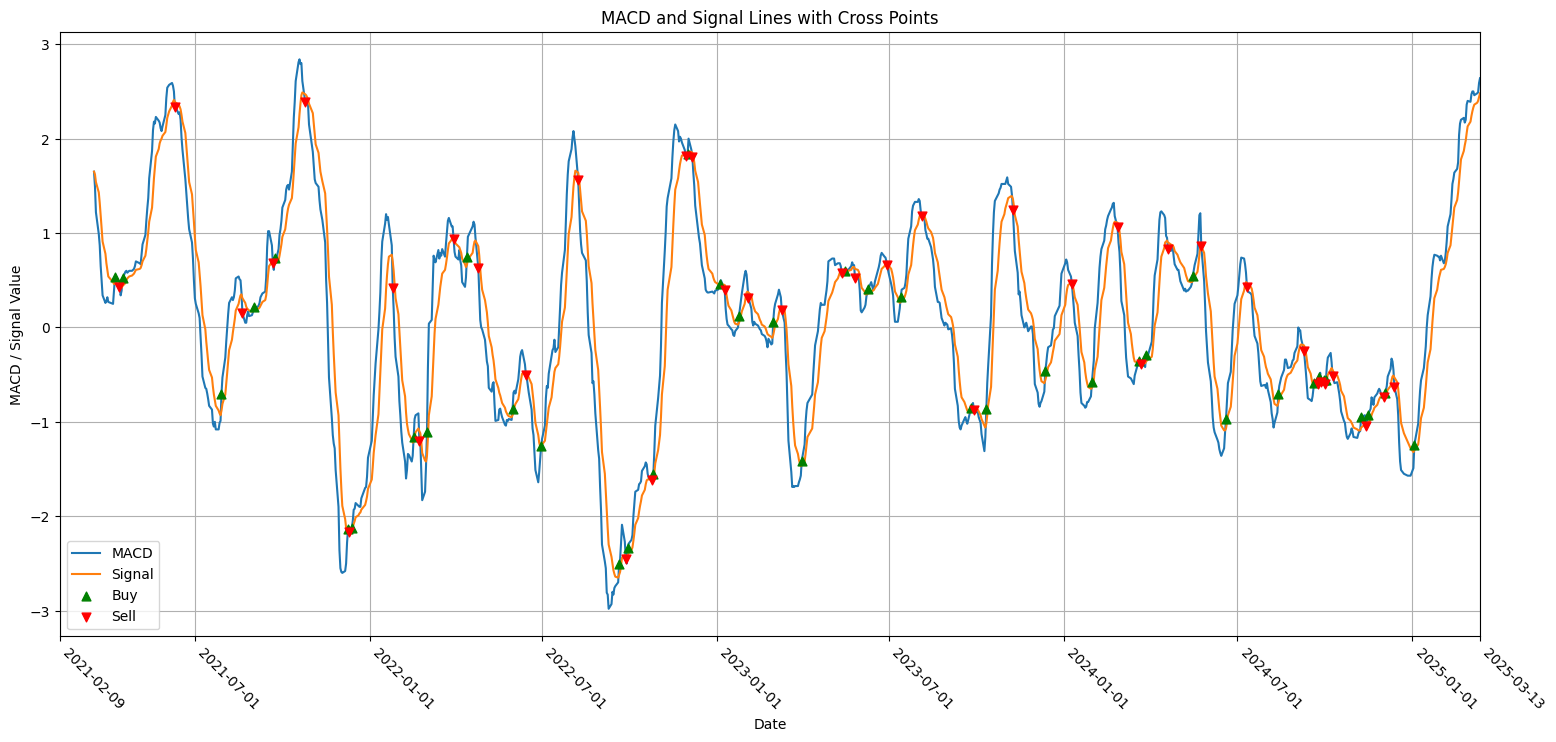

In [705]:
# MACD and Signal Lines with Cross Points
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(MS['Date'], MS.iloc[:, 1], label='MACD')
ax.plot(MS['Date'], MS['Signal'], label='Signal')

buy_points = cross_points[cross_points['Cross Point'] == 'Buy']
ax.scatter(buy_points['Date'], MS[MS['Date'].isin(buy_points['Date'])].iloc[:, 1],
           marker='^', color='green', s=40, label='Buy', zorder=2)

sell_points = cross_points[cross_points['Cross Point'] == 'Sell']
ax.scatter(sell_points['Date'], MS[MS['Date'].isin(sell_points['Date'])].iloc[:, 1],
           marker='v', color='red', s=40, label='Sell', zorder=2)


ax.set_xlabel('Date')
ax.set_ylabel('MACD / Signal Value')
ax.set_title('MACD and Signal Lines with Cross Points')
ax.legend()
ax.grid(True)
plt.tight_layout()

# Set dates ticks to display every month
locator = mdates.MonthLocator(interval=6)
ax.xaxis.set_major_locator(locator)
# Style dates
formatter = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(formatter)
# Rotate dates
plt.xticks(rotation=-45, ha='left')
first_date = stock_data['Date'].iloc[0]
last_date = stock_data['Date'].iloc[-1]
ax.set_xlim(first_date, last_date)

first_date_num = mdates.date2num(first_date)
last_date_num = mdates.date2num(last_date)
current_ticks = ax.get_xticks()
new_ticks = sorted(list(set(list(current_ticks) + [first_date_num, last_date_num])))
ax.set_xticks(new_ticks)

plt.savefig('plots/macd_signal_cross_points.png',dpi=200, bbox_inches='tight')

plt.show()

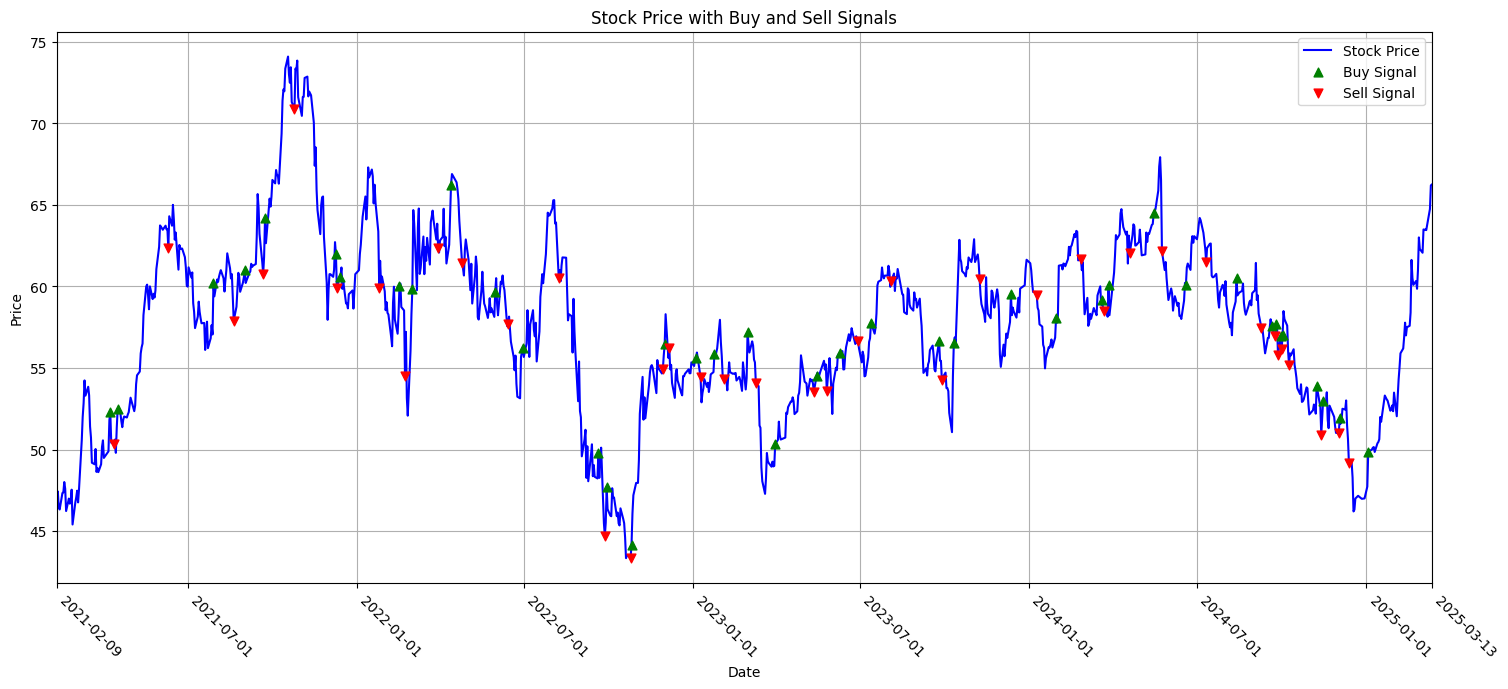

In [706]:
# Stock Price with Buy and Sell Signals
fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(stock_data['Date'], stock_data['Price'], label='Stock Price', color='blue')

buy_points_price = cross_points[cross_points['Cross Point'] == 'Buy']
ax.scatter(buy_points_price['Date'], buy_points_price['Price'],
           marker='^', color='green', s=40, label='Buy Signal', zorder=2)

sell_points_price = cross_points[cross_points['Cross Point'] == 'Sell']
ax.scatter(sell_points_price['Date'], sell_points_price['Price'],
           marker='v', color='red', s=40, label='Sell Signal', zorder=2)

ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Stock Price with Buy and Sell Signals')
ax.legend()
ax.grid(True)

locator = mdates.MonthLocator(interval=6)
ax.xaxis.set_major_locator(locator)
formatter = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(formatter)
plt.xticks(rotation=-45, ha='left')
plt.tight_layout()

first_date = stock_data['Date'].iloc[0]
last_date = stock_data['Date'].iloc[-1]
ax.set_xlim(first_date, last_date)

first_date_num = mdates.date2num(first_date)
last_date_num = mdates.date2num(last_date)
current_ticks = ax.get_xticks()
new_ticks = sorted(list(set(list(current_ticks) + [first_date_num, last_date_num])))
ax.set_xticks(new_ticks)

plt.savefig('plots/stock_price_with_signals.png', dpi=200, bbox_inches='tight')

plt.show()

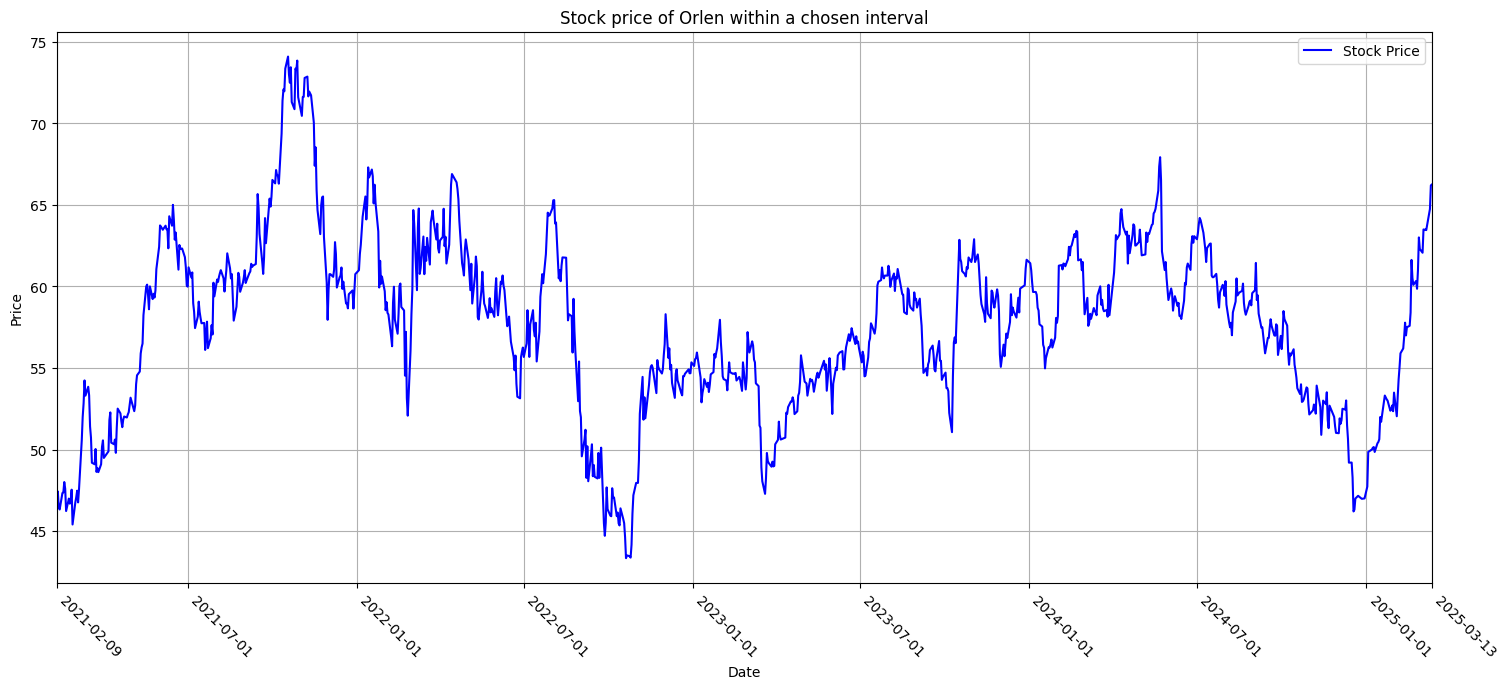

In [707]:
# Stock price
fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(stock_data['Date'], stock_data['Price'], label='Stock Price', color='blue')

ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Stock price of Orlen within a chosen interval')
ax.legend()
ax.grid(True)

locator = mdates.MonthLocator(interval=6)
ax.xaxis.set_major_locator(locator)
formatter = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(formatter)

plt.xticks(rotation=-45, ha='left')
plt.tight_layout()

first_date = stock_data['Date'].iloc[0]
last_date = stock_data['Date'].iloc[-1]
ax.set_xlim(first_date, last_date)

first_date_num = mdates.date2num(first_date)
last_date_num = mdates.date2num(last_date)
current_ticks = ax.get_xticks()
new_ticks = sorted(list(set(list(current_ticks) + [first_date_num, last_date_num])))
ax.set_xticks(new_ticks)

plt.savefig('plots/stock_price.png', dpi=200, bbox_inches='tight')

plt.show()